In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import NuSVR
#Keras imports
from keras import backend as K

from keras.layers import Input, Dense
from keras.optimizers import RMSprop, SGD, Adagrad,Adam,Adadelta,Adamax,Nadam
from keras.models import Sequential, Model
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Lambda, BatchNormalization
from keras.optimizers import SGD, Adagrad, Adam

from time import time

1 Physical GPUs, 1 Logical GPUs


Using TensorFlow backend.


In [33]:
#LINEAR
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.exp(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

#Guardar en csv columnas desde start hasta en de un dataframe.
def store_column_pd(df,columns_start,columns_end,url):
    temp_df =df.iloc[:,columns_start:columns_end]
    temp_df.to_csv(url)
    return temp_df


In [34]:
#Data from files
data_algebra = pd.read_csv("/home/dcasals/graph-edit-distance/data/algebra_features.txt")
data_medoids = pd.read_csv("/home/dcasals/graph-edit-distance/data/vectors_medoids.csv")
print(data_algebra.shape,data_medoids.shape)

(19171, 28) (19113, 28)


In [35]:
result = data_algebra.merge(data_medoids,
                 left_on='query_id',right_on='id')
print(result.shape)
result.head()

(19113, 56)


,query_id,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,...,pcs25.16,pcs25.17,pcs25.18,pcs25.19,pcs25.20,pcs25.21,pcs25.22,pcs25.23,pcs25.24,Unnamed: 27_y
0,http://lsq.aksw.org/res/DBpedia-q113812,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.333333,0.500000,0.400000,0.285714,0.200000,0.333333,0.200000,0.200000,NaN
1,http://lsq.aksw.org/res/DBpedia-q113813,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846,NaN
2,http://lsq.aksw.org/res/DBpedia-q113814,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846,NaN
3,http://lsq.aksw.org/res/DBpedia-q113815,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.200000,0.333333,0.333333,0.285714,0.400000,0.200000,0.333333,0.200000,0.200000,NaN
4,http://lsq.aksw.org/res/DBpedia-q113817,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.250000,0.400000,0.666667,0.250000,0.181818,0.250000,0.166667,0.166667,NaN


In [36]:
result = result.drop(columns=["query_id","id","Unnamed: 27_x","Unnamed: 27_y"])
result.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'path*', 'pathN*', 'path+', 'pathN+', 'notoneof',
       'tolist', 'order', 'project', 'distinct', 'reduced', 'multi', 'top',
       'group', 'assign', 'sequence', 'slice', 'treesize', 'time', 'pcs25',
       'pcs25.1', 'pcs25.2', 'pcs25.3', 'pcs25.4', 'pcs25.5', 'pcs25.6',
       'pcs25.7', 'pcs25.8', 'pcs25.9', 'pcs25.10', 'pcs25.11', 'pcs25.12',
       'pcs25.13', 'pcs25.14', 'pcs25.15', 'pcs25.16', 'pcs25.17', 'pcs25.18',
       'pcs25.19', 'pcs25.20', 'pcs25.21', 'pcs25.22', 'pcs25.23', 'pcs25.24'],
      dtype='object')

In [37]:
result.describe()

,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,path*,...,pcs25.15,pcs25.16,pcs25.17,pcs25.18,pcs25.19,pcs25.20,pcs25.21,pcs25.22,pcs25.23,pcs25.24
count,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.0,...,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000,19113.000000
mean,2.791817,2.368179,0.067860,0.680322,0.626903,0.200387,0.000314,0.001570,0.000052,0.0,...,0.432244,0.198616,0.366060,0.344247,0.419878,0.306780,0.186979,0.366060,0.223885,0.223885
std,2.424699,2.342441,0.295156,1.206685,1.607434,0.442043,0.017716,0.039588,0.007233,0.0,...,0.213312,0.133551,0.257537,0.109948,0.210350,0.114668,0.028742,0.257537,0.138379,0.138379
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.039216,0.045455,0.042553,0.040000,0.039216,0.042553,0.041667,0.042553,0.045455,0.045455
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.222222,0.133333,0.222222,0.250000,0.222222,0.222222,0.166667,0.222222,0.153846,0.153846
50%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.400000,0.153846,0.285714,0.400000,0.400000,0.250000,0.200000,0.285714,0.181818,0.181818
75%,4.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.666667,0.200000,0.333333,0.400000,0.666667,0.400000,0.200000,0.333333,0.222222,0.222222
max,36.000000,27.000000,4.000000,21.000000,14.000000,9.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
nunique = result.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
print("Remove columns with same values: {}".format(cols_to_drop))
result = result.drop(cols_to_drop, axis=1)
result.shape

Remove columns with same values: Index(['path*', 'pathN*', 'path+', 'pathN+', 'notoneof', 'tolist', 'multi',
       'top', 'assign', 'sequence'],
      dtype='object')


(19113, 42)

In [39]:
new_cols = list(result.columns[:-25]) + ['pcs'+str(i) for i in list(range(0,25))]
result.columns = new_cols

In [40]:
result = result[result['time'] < 15000]
X_temp, X_test, y_temp, y_test = train_test_split(
    result.drop(columns=['time']), result['time'], test_size=0.25, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.30, random_state=42,shuffle=True)
print("Shapes : Train: {} Val: {}, Test: {}".format(X_train.shape, X_val.shape, X_test.shape))

Shapes : Train: (9947, 41) Val: (4264, 41), Test: (4737, 41)


In [41]:
X_train.head()

,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,order,...,pcs15,pcs16,pcs17,pcs18,pcs19,pcs20,pcs21,pcs22,pcs23,pcs24
15051,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.153846,0.285714,0.50000,0.400000,0.285714,0.200000,0.285714,0.181818,0.181818
278,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.142857,0.250000,0.40000,0.666667,0.222222,0.166667,0.250000,0.166667,0.166667
13390,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.153846,0.285714,0.50000,0.400000,0.285714,0.200000,0.285714,0.181818,0.181818
17106,4.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.222222,0.181818,0.400000,0.25000,0.222222,0.400000,0.222222,0.400000,0.222222,0.222222
1225,16.0,16.0,2.0,1.0,12.0,2.0,0.0,0.0,0.0,0.0,...,0.048780,0.058824,0.054054,0.04878,0.048780,0.052632,0.051282,0.054054,0.057143,0.057143


In [42]:
#Standarizar
scalerx = StandardScaler()
x_train_scaled = scalerx.fit_transform(X_train);
x_val_scaled = scalerx.transform(X_val);
x_test_scaled = scalerx.fit_transform(X_test);

scaled_df_train = pd.DataFrame(x_train_scaled, index=X_train.index, columns=X_train.columns)
scaled_df_val = pd.DataFrame(x_val_scaled, index=X_val.index, columns=X_train.columns)
scaled_df_test = pd.DataFrame(x_test_scaled, index=X_test.index, columns=X_train.columns)

In [43]:
#Save data
scaled_df_train.join(y_train).to_csv("/home/dcasals/jupyter/mlproject/xtrain_std.csv", index=False)
scaled_df_val.join(y_val).to_csv("/home/dcasals/jupyter/mlproject/xval_std.csv", index=False)
scaled_df_test.join(y_test).to_csv("/home/dcasals/jupyter/mlproject/xtest_std.csv", index=False)

In [46]:
#READ data
scaled_df_train = pd.read_csv("/home/dcasals/jupyter/mlproject/xtrain_std.csv")
scaled_df_val   = pd.read_csv("/home/dcasals/jupyter/mlproject/xval_std.csv")
scaled_df_test  = pd.read_csv("/home/dcasals/jupyter/mlproject/xtest_std.csv")

y_train = scaled_df_train['time']
y_val   = scaled_df_val['time']
y_test  = scaled_df_test['time']
scaled_df_train = scaled_df_train.drop(columns=['time'])
scaled_df_val = scaled_df_val.drop(columns=['time'])
scaled_df_test = scaled_df_test.drop(columns=['time'])

In [47]:
scaled_df_train = scaled_df_train[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_val = scaled_df_val[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_test = scaled_df_test[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_train.shape,scaled_df_val.shape,scaled_df_test.shape

((9947, 34), (4264, 34), (4737, 34))

In [167]:
# df_org_mayor = scaled_df_train.loc[(scaled_df_train['time'] >= 1500)].sample(n=5000,random_state=42,replace=True)
# scaled_df_train = pd.concat([scaled_df_train,df_org_mayor])
# # scaled_df_train = df_org_2
# # df_org_mayor = scaled_df_train.loc[(scaled_df_train['time'] >= 1500)].sample(n=100000,random_state=10,replace=True)
# # # print(df_org_mayor)
# # scaled_df_train = pd.concat([scaled_df_train,df_org_mayor])
# y_train = scaled_df_train['time']
# scaled_df_train = scaled_df_train.drop(columns=['time'])

In [48]:
scaled_df_train.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24'],
      dtype='object')

In [49]:
#Pass Target to log scale
y_train_log = np.log(y_train.values.reshape(-1, 1))
y_val_log = np.log(y_val.values.reshape(-1, 1))
y_test_log = np.log(y_test.values.reshape(-1, 1))

#Standarizar target
scalery = StandardScaler()
y_train_log_std = scalery.fit_transform(y_train_log)
y_val_log_std = scalery.transform(y_val_log)
y_test_log_std = scalery.transform(y_test_log)

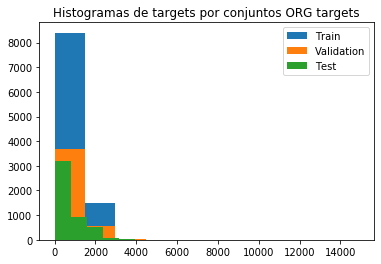

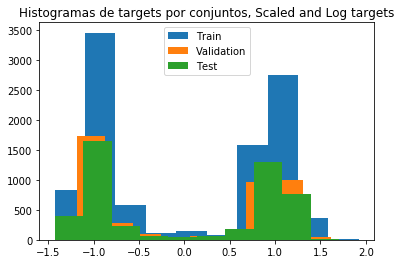

In [50]:
plt.title("Histogramas de targets por conjuntos ORG targets")
plt.hist(y_train.values.reshape(-1, 1),label="Train")
plt.hist(y_val.values.reshape(-1, 1),label="Validation")
plt.hist(y_test.values.reshape(-1, 1),label="Test")
plt.legend()
plt.show()
plt.title("Histogramas de targets por conjuntos, Scaled and Log targets")
plt.hist(y_train_log_std,label="Train")
plt.hist(y_val_log_std,label="Validation")
plt.hist(y_test_log_std,label="Test")
plt.legend()
plt.show()

<span style="color:blue">

### Entrenando RNN. Primer enfoque

- Datos escalados
- Targets escalados y en escala logarítmica.


In [63]:
# Set callback functions to early stop training and save the best model so far
from sklearn.metrics import r2_score

def tune_params(dftable, x_train, y_train,x_val, y_val,scalery, n1,n2,n3,epochs,optimizer,dropout):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata_{}_{}_{}.h5'.format(n1,n2,n3),
                                      monitor='val_loss', save_best_only=True
                                     )
    ]

    model = Sequential()
    model.add(Dense(n1, activation='relu',kernel_initializer='glorot_uniform'))
#     model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))
    history_org = model.fit(x_train.values, y_train,
        epochs=epochs,
        batch_size=120,
        validation_data=(x_val.values, y_val),
        callbacks=callbacks_best,
        verbose=False
    )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    timeconsume = round(t1-t0,3)
    print("training time {}",format(timeconsume))
#     print(model.summary())

    # serialize model to JSON
#     model_json = model.to_json()
#     optim_name= str(optimizer).split(".")[2].split(" ")[0]
#     with open("/home/dcasals/jupyter/mlproject/models/model_"+"_".join([str(int(rmseval)), optim_name, str(n1),str(n2),str(n3),str(epochs),str(dropout)])+".json", "w") as json_file:
#         json_file.write(model_json)
#     # serialize weights to HDF5
#     model.save_weights("model.h5")
    print("Saved model to disk")
    return [model, history_org, dftable,timeconsume]


In [ ]:
# import random
# optimizer=Adam(learning_rate=0.00015)
# epochs=450
# dropout=0.25
# dftable = pd.DataFrame(columns=[])
# for idx,item in enumerate(list(range(1,15))):
#     n1 = random.randrange(260,360,10)
#     n2 = random.randrange(160,360,10)
#     n3 = random.randrange(200,340,15)
#     model_trained = tune_params(dftable, scaled_df_train,y_train_log_std, scaled_df_val, y_val_log_std,scalery, n1,n2,n3,epochs,optimizer,dropout)
#     dftable = model_trained[2]

In [68]:
import random
optimizer=Adam(learning_rate=0.00015)
epochs=450
dropout=0.25
max_r2=0
min_rmse=10000
dftable = pd.DataFrame(columns=[])
best_l1 = 1
best_l2 = 1
best_l3 = 1
dataout = []
for idx,item in enumerate(list(range(1,15))):
    n1 = random.randrange(260,300,20)
    n2 = random.randrange(300,350,20)
    n3 = random.randrange(200,300,20)
    model_trained = tune_params(dftable, scaled_df_train, y_train_log_std, scaled_df_val, y_val_log_std, scalery, n1,n2,n3,epochs,optimizer,dropout)
    dataout.append(model_trained)
    dftable = model_trained[2]
    y_pred_train = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_train).reshape(-1, 1)))
    y_pred_val = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_val).reshape(-1, 1)))
    y_pred_test = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_test).reshape(-1, 1)))
            
    current_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    if current_rmse < min_rmse:
        best_l1 = n1
        best_l2 = n2
        best_l3 = n3

        min_rmse = current_rmse
        mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mse_val  =  np.sqrt(mean_squared_error(y_val, y_pred_val))
        mse_test =  np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_train = r2_score(y_train, y_pred_train)
        r2_val  =  r2_score( y_val, y_pred_val)
        r2_test =  r2_score(y_test, y_pred_test)

        dftable = dftable.append(pd.Series([n1, n2, n3, mse_train, mse_val, mse_test,r2_train, r2_val,r2_test]), ignore_index=True)
        print("RMSE Train",n1, n2, n3, mse_train)
        print("RMSE VAL  ",n1, n2, n3, mse_val)
        print("RMSE TEST ",n1, n2, n3, mse_test)
        print("R2 Train",  n1, n2, n3, r2_train)
        print("R2 VAL  ",  n1, n2, n3, r2_val)
        print("R2 TEST ",  n1, n2, n3, r2_test)
        print("____________________")
dftable

before train: Init time: 1583871710.921
after train, finish time: 1583871905.999
training time {} 195.078
Saved model to disk
RMSE Train 280 340 280 667.7249945703904
RMSE VAL   280 340 280 613.5407668536627
RMSE TEST  280 340 280 515.5052165274504
R2 Train 280 340 280 0.4332059370502368
R2 VAL   280 340 280 0.4344834024402474
R2 TEST  280 340 280 0.5279366276735211
____________________
before train: Init time: 1583871906.854
after train, finish time: 1583872126.999
training time {} 220.146
Saved model to disk
RMSE Train 280 320 240 641.5687891946544
RMSE VAL   280 320 240 591.4365570659859
RMSE TEST  280 320 240 491.1443724812426
R2 Train 280 320 240 0.47674127004623046
R2 VAL   280 320 240 0.4744974398636618
R2 TEST  280 320 240 0.571498328484576
____________________
before train: Init time: 1583872127.796
after train, finish time: 1583872286.228
training time {} 158.432
Saved model to disk
before train: Init time: 1583872287.027
after train, finish time: 1583872538.717
training time

,0,1,2,3,4,5,6,7,8
0,280.0,340.0,280.0,667.724995,613.540767,515.505217,0.433206,0.434483,0.527937
1,280.0,320.0,240.0,641.568789,591.436557,491.144372,0.476741,0.474497,0.571498
2,260.0,300.0,240.0,628.109825,584.303888,481.832513,0.498465,0.487096,0.587593


In [62]:
y_pred = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_train.values).reshape(-1, 1)))
y_pred_val = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_val.values).reshape(-1, 1)))

r2_train = r2_score(y_train, y_pred)
r2_val  =  r2_score( y_val, y_pred_val)
r2_train,r2_val

(0.47419900477928645, 0.4733220472796885)

In [71]:
dftable

,Layer1,Layer2,Layer3,MSE_TRAIN,MES_VAL,MSE_TEST,R2_TRAIN,R2_VAL,R2_TEST
0,280.0,340.0,280.0,667.724995,613.540767,515.505217,0.433206,0.434483,0.527937
1,280.0,320.0,240.0,641.568789,591.436557,491.144372,0.476741,0.474497,0.571498
2,260.0,300.0,240.0,628.109825,584.303888,481.832513,0.498465,0.487096,0.587593


In [72]:
dftable.columns = ['Layer1','Layer2','Layer3', 'MSE_TRAIN', 'MES_VAL','MSE_TEST','R2_TRAIN', 'R2_VAL','R2_TEST']
print(dftable[['Layer1','Layer2','Layer3', 'MSE_TRAIN', 'MES_VAL','R2_TRAIN', 'R2_VAL']].sort_values('MES_VAL', axis=0).to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
 Layer1 &  Layer2 &  Layer3 &   MSE\_TRAIN &     MES\_VAL &  R2\_TRAIN &    R2\_VAL \\
\midrule
  260.0 &   300.0 &   240.0 &  628.109825 &  584.303888 &  0.498465 &  0.487096 \\
  280.0 &   320.0 &   240.0 &  641.568789 &  591.436557 &  0.476741 &  0.474497 \\
  280.0 &   340.0 &   280.0 &  667.724995 &  613.540767 &  0.433206 &  0.434483 \\
\bottomrule
\end{tabular}



before train: Init time: 1573612137.386
Train on 9947 samples, validate on 4264 samples
Epoch 1/500
9947/9947 [==============================] - 1s 121us/step - loss: 0.5256 - mae: 0.5827 - coeff_determination: 0.4710 - rmse: 2.0071 - val_loss: 0.3379 - val_mae: 0.3864 - val_coeff_determination: 0.6546 - val_rmse: 1.6623
Epoch 2/500
9947/9947 [==============================] - 1s 82us/step - loss: 0.3793 - mae: 0.4590 - coeff_determination: 0.6176 - rmse: 1.7574 - val_loss: 0.2978 - val_mae: 0.3185 - val_coeff_determination: 0.6955 - val_rmse: 1.5762
Epoch 3/500
9947/9947 [==============================] - 1s 84us/step - loss: 0.3430 - mae: 0.4180 - coeff_determination: 0.6539 - rmse: 1.6940 - val_loss: 0.2879 - val_mae: 0.3290 - val_coeff_determination: 0.7058 - val_rmse: 1.5739
Epoch 4/500
9947/9947 [==============================] - 1s 86us/step - loss: 0.3307 - mae: 0.4012 - coeff_determination: 0.6670 - rmse: 1.7801 - val_loss: 0.2753 - val_mae: 0.3137 - val_coeff_determination: 0

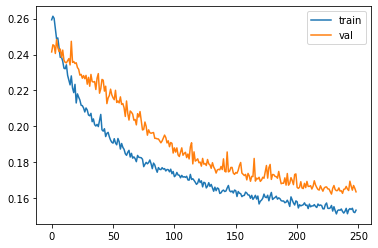

In [230]:
n1=280
n2=320
n3=280
epochs=500
dropout=0.30
optimizer=Adam(learning_rate=0.00015)
model_trained = tune_params(dftable, scaled_df_train,y_train_log_std, scaled_df_val, y_val_log_std,scalery, n1,n2,n3,epochs,optimizer,dropout)
plt.plot(model_trained[1].history['loss'][13:],label="train")
plt.plot(model_trained[1].history['val_loss'][13:],label="val")
plt.legend()
plt.show()
y_pred_org_test = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_pred_org_test, y_test))
rmseval

In [55]:
y_pred_org_test = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_pred_org_test, y_test))
rmseval


489.9161049543266

In [59]:
y_pred_org_test = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_train.values).reshape(-1, 1)))
rmseval = r2_score(y_train,y_pred_org_test)
rmseval

0.47419900477928645

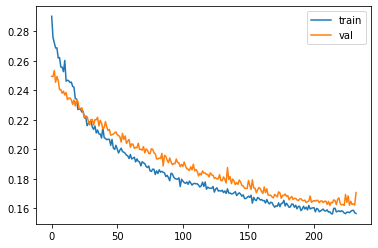

In [116]:
history_org = model_trained[1] 
model = model_trained[0]
#Prediction
y_pred_org_train = np.exp(scalery.inverse_transform(model.predict(scaled_df_train.values).reshape(-1, 1)))
y_pred_org_val = np.exp(scalery.inverse_transform(model.predict(scaled_df_val.values).reshape(-1, 1)))

rmse_train = np.sqrt(mean_squared_error(y_pred_org_train, y_train))
rmseval = np.sqrt(mean_squared_error(y_pred_org_val, y_val))
plt.plot(history_org.history['loss'][13:],label="train")
plt.plot(history_org.history['val_loss'][13:],label="val")
plt.legend()
plt.show()


In [118]:
#Imprimir la  predicción en conjunto de validación
a = y_pred_org_val.reshape(1, -1)
for i in range(y_val.shape[0]):
#     print(y_val[i])
    print("%10.3f,  %10.3f"%(a[0][i],y_val.values[i]))

     3.160,       3.000
   617.584,     586.000
     4.193,       3.000
     4.437,       4.000
     3.116,       9.000
   816.014,    1192.000
     4.437,       4.000
     4.437,       4.000
     4.437,       4.000
  1243.222,    1216.000
     9.825,       3.000
   895.329,    1217.000
     4.437,       4.000
    12.489,      10.000
    17.731,       8.000
  1050.817,    1468.000
  1475.557,    2006.000
     3.437,       2.000
    89.052,    1169.000
   866.542,    1184.000
     4.437,       4.000
     2.370,       3.000
   952.031,    1322.000
     4.437,       4.000
     3.561,       3.000
   895.329,     829.000
   188.641,     661.000
   895.329,     945.000
     3.160,       3.000
     4.437,       3.000
     3.561,       2.000
    17.731,    2410.000
   949.041,    1250.000
   895.329,    1238.000
     4.437,       4.000
     4.437,       4.000
    99.146,     130.000
     9.197,    1094.000
   796.891,    1531.000
  1198.447,    1807.000
   981.990,    1028.000
  1095.338,    2

In [236]:
y_pred_org_test = np.exp(scalery.inverse_transform(model.predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_pred_org_test, y_test))
rmseval

500.39266779825715

### Update, columnas originales del paper.


In [8]:
scaled_df_train.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24'],
      dtype='object')

In [12]:
scaled_df_train = scaled_df_train[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_val = scaled_df_val[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_test = scaled_df_test[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_train.shape,scaled_df_val.shape,scaled_df_test.shape

((9947, 34), (4264, 34), (4737, 34))

In [ ]:
n1=280
n2=320
n3=280
epochs=500
dropout=0.30
optimizer=Adam(learning_rate=0.00015)
model_trained = tune_params(dftable, scaled_df_train,y_train_log_std, scaled_df_val, y_val_log_std,scalery, n1,n2,n3,epochs,optimizer,dropout)
plt.plot(model_trained[1].history['loss'][13:],label="train")
plt.plot(model_trained[1].history['val_loss'][13:],label="val")
plt.legend()
plt.show()
y_pred_org_test = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_pred_org_test, y_test))
rmseval

In [73]:
def train_autoencoder(x_train, x_val,encoding_dim,verbose):
    # Set callback functions to early stop training and save the best model so far
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=10),
                ]
    # def autoencode_pd(df):
    # this is the size of our encoded representations
    # this is our input placeholder
    input_img = Input(shape=(x_train.shape[1],))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x_train.shape[1], activation='linear')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer=Nadam(learning_rate=0.0001), loss='mse')
    print(autoencoder.summary())
    autoencoder.fit(x_train, x_train,
                    epochs=300,
             batch_size=100,
                    shuffle=True,
                    validation_data=(x_val, x_val),
                    verbose=verbose,
                    callbacks=callbacks_best)
    return autoencoder

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 34)                0         
_________________________________________________________________
dense_165 (Dense)            (None, 20)                700       
_________________________________________________________________
dense_166 (Dense)            (None, 34)                714       
Total params: 1,414
Trainable params: 1,414
Non-trainable params: 0
_________________________________________________________________
None


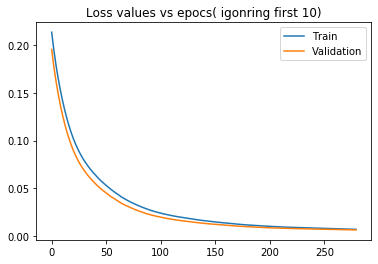

In [74]:
autoencoder = train_autoencoder(scaled_df_train, scaled_df_val, 20,verbose=False)
plt.plot(autoencoder.history.history['loss'][20:],label="Train")
plt.plot(autoencoder.history.history['val_loss'][20:],label="Validation")
plt.title("Loss values vs epocs( igonring first 10)")
plt.legend()
plt.show()

In [75]:
autoencoder.save("autoencoder_newdata.h5")
# encoder.save("encoder.h5")

In [79]:
best_l1 , best_l2, best_l3

(260, 300, 240)

In [82]:
# Set callback functions to early stop training and save the best model so far
def tune_params_autoencoder(autoencoder, x_train, y_train, x_val, y_val, n1, n2, n3, scalery, epochs, optimizer, dropout):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata.h5'.format(n1,n2,n3),
                                      monitor='val_loss', save_best_only=True
                                     )]

    model = Sequential()
    model.add(autoencoder.layers[0])
    model.add(autoencoder.layers[1])
    model.add(Dense(n1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))
    history_org = model.fit(x_train.values, y_train,
                    epochs=epochs,
                    batch_size=120,
                    validation_data=(x_val.values, y_val),
                    callbacks=callbacks_best,
                    verbose=False
                     )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0, 3)))
    print(model.summary())

    #Prediction
    y_pred_org_train = np.exp(scalery.inverse_transform(model.predict(x_train.values).reshape(-1, 1)))
    y_pred_org_val = np.exp(scalery.inverse_transform(model.predict(x_val.values).reshape(-1, 1)))

    rmse_train = np.sqrt(mean_squared_error(y_pred_org_train, y_train))
    rmseval = np.sqrt(mean_squared_error(y_pred_org_val, y_val))
    
    print("RMSE Train", np.sqrt(mean_squared_error(y_train, y_pred_org_train)))
    print("RMSE VAL", np.sqrt(mean_squared_error(y_val, y_pred_org_val)))
    print("R2 Train", r2_score(y_train, y_pred_org_train))
    print("R2 VAL", r2_score(y_val, y_pred_org_val))
    # serialize model to JSON
#     model_json = model.to_json()
#     optim_name= str(optimizer).split(".")[2].split(" ")[0]
#     with open("/home/dcasals/jupyter/mlproject/models/model_"+"_".join(["autoencoder", str(int(rmseval)), optim_name, str(n1),str(n2),str(n3),str(epochs),str(dropout)])+".json", "w") as json_file:
#         json_file.write(model_json)
#     # serialize weights to HDF5
#     model.save_weights("model.h5")
    return [model, history_org, round(t1-t0, 3)]

### Aplicación del modelo respecto al entrenamiento de un autoencoder como parte inicial del modelo.

In [87]:
epochs=450
dropout=0.25
optimizer=Adam(learning_rate=0.00015)
model_trained_aenc = tune_params_autoencoder(
    autoencoder,
    scaled_df_train,
    y_train_log_std,
    scaled_df_val,
    y_val_log_std,
    best_l1 , 
    best_l2, 
    best_l3,
    scalery,
    epochs,
    optimizer,
    dropout)

y_pred_org_test = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_test, y_pred_org_test ))
r2val = r2_score(y_test, y_pred_org_test )

print("MSE:{} y R2: {}".format(rmseval, r2val))

before train: Init time: 1583879078.777
after train, finish time: 1583879307.301
training time {} 228.524
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 20)                700       
_________________________________________________________________
dense_175 (Dense)            (None, 260)               5460      
_________________________________________________________________
dropout_87 (Dropout)         (None, 260)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 300)               78300     
_________________________________________________________________
dropout_88 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 240)               72240     
_____________

In [89]:
y_pred_org_test = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_test.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_pred_org_test, y_test))
rmseval

486.7141732464315

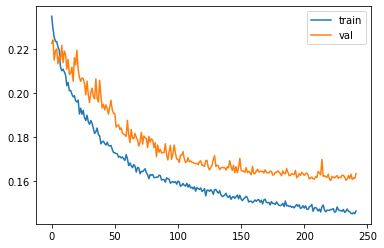

In [90]:
history_org_enc = model_trained_aenc[1] 
model_trained_aenc = model_trained_aenc[0]
#Prediction
y_pred_org_train = np.exp(scalery.inverse_transform(model_trained_aenc.predict(scaled_df_train.values).reshape(-1, 1)))
y_pred_org_val = np.exp(scalery.inverse_transform(model_trained_aenc.predict(scaled_df_val.values).reshape(-1, 1)))

rmse_train = np.sqrt(mean_squared_error(y_pred_org_train, y_train))
rmseval = np.sqrt(mean_squared_error(y_pred_org_val, y_val))
plt.plot(history_org_enc.history['loss'][13:],label="train")
plt.plot(history_org_enc.history['val_loss'][13:],label="val")
plt.legend()
plt.show()

**Baseline, SVR con datos nuevos.**

Se entrena una Nu-SVR tal como propone el paper original con los datos nuevos.

In [103]:
def baseline_svr(C,nu,dftable):
    
    sv = NuSVR(C=300, nu=0.3)

    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))

    sv.fit(scaled_df_train.values, y_train_log_std)
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0,3)))
    y_train_hat_svr = scalery.inverse_transform(sv.predict(scaled_df_train.values).reshape(-1, 1))
    y_val_hat_svr = scalery.inverse_transform(sv.predict(scaled_df_val.values).reshape(-1, 1))
    y_test_hat_svr = scalery.inverse_transform(sv.predict(scaled_df_test.values).reshape(-1, 1))

    #MSE for valid
    mse_svr_curr = np.sqrt(mean_squared_error(y_train_hat_svr,y_train))
    mse_svr_val_curr = np.sqrt(mean_squared_error(y_val_hat_svr,y_val))
    mse_svr_test_curr = np.sqrt(mean_squared_error(y_test_hat_svr,y_test))

    scores_train_curr = sv.score(scaled_df_train.values, y_train_log_std)
    scores_val_curr = sv.score(scaled_df_val.values,   y_val_log_std)
    scores_test_curr = sv.score(scaled_df_test,   y_test_log_std)

    print("MSE val: {}, MSE train {}, R2 val:{}, R2 train:{}".format(mse_svr_val_curr,mse_svr_curr,scores_val_curr,scores_train_curr))
    print("MSE test: {}, R2 test:{}".format(mse_svr_test_curr, scores_test_curr))
    dftable = dftable.append(pd.Series([
                                C, nu, mse_svr_curr, mse_svr_val_curr, mse_svr_test_curr,
                                scores_train_curr, scores_val_curr, scores_test_curr,
                                round(t1-t0,3)]), ignore_index=True
                            )
    return sv, dftable

In [ ]:
result_baseline_model = []
dftable = pd.DataFrame(columns=[])
for i in range(1,10):
    C = random.randrange(100,350,20)
    nu = random.randrange(10,50,5)/100
    result_baseline_model
    sv,dftable = baseline_svr(C, nu, dftable)
    result_baseline_model.append(sv)

before train: Init time: 1583888935.542


/home/dcasals/rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [102]:
random.randrange(10,50,5)/100

0.3

### **Resultados del baseline:**

**El baseline obtiene indicadores peores que el modelo de RNN.**

- MSE   val: 1004.0259378113022,  R2 val:0.7943500135455264
- MSE train: 1074.3131650519306,  R2 train:0.8229526882510579
- MSE  test: 946.3464385559547 ,  R2 test:0.7979615897660082

### Nuevo enfoque

**Datos obtenidos conciderando los predicados que más registros tienen en Dbpedia.**



In [9]:
ds_predic_feat = pd.read_csv("/home/dcasals/graph-edit-distance/predicates_features_output.csv")

In [10]:
ds_predic_feat.describe()

,OTHER,<http://www.w3.org/2002/07/owl#sameAs>,<http://purl.org/dc/terms/subject>,<http://www.w3.org/2000/01/rdf-schema#label>,<http://www.w3.org/ns/prov#wasDerivedFrom>,<http://dbpedia.org/ontology/wikiPageID>,<http://dbpedia.org/ontology/wikiPageRevisionID>,<http://purl.org/dc/elements/1.1/language>,<http://xmlns.com/foaf/0.1/primaryTopic>,<http://xmlns.com/foaf/0.1/isPrimaryTopicOf>,...,<http://dbpedia.org/property/flavour>,<http://dbpedia.org/property/bo>,<http://dbpedia.org/property/buschCarTeam>,<http://dbpedia.org/property/majorsites>,<http://dbpedia.org/property/1v4b>,<http://dbpedia.org/property/5a>,<http://dbpedia.org/property/seats1Last>,null,null.1,Unnamed: 10003
count,19172.000000,19172.000000,19172.0,19172.000000,19172.0,19172.0,19172.0,19172.0,19172.000000,19172.0,...,19172.0,19172.0,19172.0,19172.0,19172.0,19172.0,19172.0,19172.0,19172.0,0.0
mean,0.779053,0.005164,0.0,0.295848,0.0,0.0,0.0,0.0,0.000678,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
std,1.105278,0.083757,0.0,0.524102,0.0,0.0,0.0,0.0,0.059989,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
min,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
25%,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
50%,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
75%,1.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
max,12.000000,2.000000,0.0,4.000000,0.0,0.0,0.0,0.0,8.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [28]:
nuniquepred = ds_predic_feat.apply(pd.Series.nunique)
cols_to_droppred = nuniquepred[nuniquepred == 1].index
print("Remove columns with same values: {}".format(cols_to_droppred))
ds_predic_feat = ds_predic_feat.drop(cols_to_droppred, axis=1)
ds_predic_feat.head()

Remove columns with same values: Index(['<http://purl.org/dc/terms/subject>',
       '<http://www.w3.org/ns/prov#wasDerivedFrom>',
       '<http://dbpedia.org/ontology/wikiPageID>',
       '<http://dbpedia.org/ontology/wikiPageRevisionID>',
       '<http://purl.org/dc/elements/1.1/language>',
       '<http://xmlns.com/foaf/0.1/isPrimaryTopicOf>',
       '<http://dbpedia.org/ontology/wikiPageExternalLink>',
       '<http://dbpedia.org/ontology/wikiPageRedirects>',
       '<http://purl.org/linguistics/gold/hypernym>',
       '<http://purl.org/dc/elements/1.1/rights>',
       ...
       '<http://dbpedia.org/property/anchor>',
       '<http://dbpedia.org/property/flavour>',
       '<http://dbpedia.org/property/bo>',
       '<http://dbpedia.org/property/buschCarTeam>',
       '<http://dbpedia.org/property/majorsites>',
       '<http://dbpedia.org/property/1v4b>',
       '<http://dbpedia.org/property/5a>',
       '<http://dbpedia.org/property/seats1Last>', 'null', 'null.1'],
      dtype='obj

,id,OTHER,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.w3.org/2000/01/rdf-schema#label>,<http://xmlns.com/foaf/0.1/primaryTopic>,<http://www.w3.org/2000/01/rdf-schema#comment>,<http://dbpedia.org/ontology/abstract>,<http://xmlns.com/foaf/0.1/name>,<http://www.w3.org/2004/02/skos/core#broader>,<http://dbpedia.org/ontology/team>,...,<http://dbpedia.org/property/died>,<http://dbpedia.org/property/regierungsbezirk>,<http://dbpedia.org/property/resides>,<http://dbpedia.org/property/alternativeNames>,<http://dbpedia.org/property/companyName>,<http://dbpedia.org/property/placeOfBirth>,<http://dbpedia.org/property/firstHeld>,<http://dbpedia.org/property/my>,<http://dbpedia.org/property/postcodeDistrict>,Unnamed: 10003
0,http://lsq.aksw.org/res/DBpedia-q113812,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,http://lsq.aksw.org/res/DBpedia-q113813,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,http://lsq.aksw.org/res/DBpedia-q113814,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,http://lsq.aksw.org/res/DBpedia-q113815,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,http://lsq.aksw.org/res/DBpedia-q113817,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [ ]:
ds_predic_feat = ds_predic_feat.drop(columns=['Unnamed: 10003'])

In [33]:
ds_predic_feat.shape, scaled_df_train.shape

((19172, 381), (9947, 41))

In [101]:
#Data from files
data_algebra = pd.read_csv("/home/dcasals/graph-edit-distance/data/algebra_features.txt")
data_medoids = pd.read_csv("/home/dcasals/graph-edit-distance/data/vectors_medoids.csv")
print(data_algebra.shape,data_medoids.shape)
result = data_algebra.merge(data_medoids,
                 left_on='query_id',right_on='id')
print(result.shape)
result.head()
result = result.drop(columns=["id","Unnamed: 27_x","Unnamed: 27_y"])
result.columns
nunique = result.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
print("Remove columns with same values: {}".format(cols_to_drop))
result = result.drop(cols_to_drop, axis=1)
new_cols = list(result.columns[:-25]) + ['pcs'+str(i) for i in list(range(0,25))]
result.columns = new_cols

(19171, 28) (19113, 28)
(19113, 56)
Remove columns with same values: Index(['path*', 'pathN*', 'path+', 'pathN+', 'notoneof', 'tolist', 'multi',
       'top', 'assign', 'sequence'],
      dtype='object')


In [102]:
resultwith_predictfeact = result.merge(ds_predic_feat,
                 left_on='query_id',right_on='id')
print(resultwith_predictfeact.shape)

(19113, 424)


In [103]:
resultwith_predictfeact = resultwith_predictfeact.drop(columns=['id','query_id'])
def get_tvalt_split(result):
    result = result[result['time'] < 15000]
    X_temp, X_test, y_temp, y_test = train_test_split(
        result.drop(columns=['time']), result['time'], test_size=0.25, random_state=42, shuffle=True)

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.30, random_state=42,shuffle=True)
#     print("Shapes : Train: {} Val: {}, Test: {}".format(X_train.shape, X_val.shape, X_test.shape))
    return X_train, X_val, X_test, y_train, y_val, y_test
X_train, X_val, X_test, y_train, y_val, y_test = get_tvalt_split(resultwith_predictfeact)
print("Shapes : Train: {} Val: {}, Test: {}".format(X_train.shape, X_val.shape, X_test.shape))

Shapes : Train: (9947, 421) Val: (4264, 421), Test: (4737, 421)


In [104]:
#Standarizar
scalerx = StandardScaler()
x_train_scaled = scalerx.fit_transform(X_train);
x_val_scaled = scalerx.transform(X_val);
x_test_scaled = scalerx.fit_transform(X_test);

scaled_df_train = pd.DataFrame(x_train_scaled, index=X_train.index, columns=X_train.columns)
scaled_df_val = pd.DataFrame(x_val_scaled, index=X_val.index, columns=X_train.columns)
scaled_df_test = pd.DataFrame(x_test_scaled, index=X_test.index, columns=X_train.columns)

In [105]:
#Save data
scaled_df_train.join(y_train).to_csv("/home/dcasals/jupyter/mlproject/xtrainpredicates_std.csv", index=False)
scaled_df_val.join(y_val).to_csv("/home/dcasals/jupyter/mlproject/xvalpredicates_std.csv", index=False)
scaled_df_test.join(y_test).to_csv("/home/dcasals/jupyter/mlproject/xtestpredicates_std.csv", index=False)

In [124]:
#READ data
scaled_df_trainapp = pd.read_csv("/home/dcasals/jupyter/mlproject/xtrainpredicates_std.csv")
scaled_df_valapp   = pd.read_csv("/home/dcasals/jupyter/mlproject/xvalpredicates_std.csv")
scaled_df_testapp  = pd.read_csv("/home/dcasals/jupyter/mlproject/xtestpredicates_std.csv")

y_trainapp = scaled_df_trainapp['time']
y_valapp   = scaled_df_valapp['time']
y_testapp  = scaled_df_testapp['time']
scaled_df_trainapp = scaled_df_trainapp.drop(columns=['time'])
scaled_df_valapp = scaled_df_valapp.drop(columns=['time'])
scaled_df_testapp = scaled_df_testapp.drop(columns=['time'])

In [185]:
print("Cantidad de ejemplos de entrenamiento {}".format(scaled_df_trainapp.shape))
print("Cantidad de ejemplos de validación  {}".format(scaled_df_valapp.shape))
print("Cantidad de ejemplos de testing  {}".format(scaled_df_testapp.shape))

print("Conjuntos distintos de datos {}".format(np.unique(scaled_df_trainapp,axis=0).shape))

Cantidad de ejemplos de entrenamiento (9947, 421)
Cantidad de ejemplos de validación  (4264, 421)
Cantidad de ejemplos de testing  (4737, 421)
Conjuntos distintos de datos (2413, 421)


In [126]:
#Pass Target to log scale
y_train_logapp = np.log(y_trainapp.values.reshape(-1, 1))
y_val_logapp = np.log(y_valapp.values.reshape(-1, 1))
y_test_logapp = np.log(y_testapp.values.reshape(-1, 1))
#Standarizar target
scaleryapp = StandardScaler()
y_train_log_stdapp = scaleryapp.fit_transform(y_train_logapp)
y_val_log_stdapp = scaleryapp.transform(y_val_logapp)
y_test_log_stdapp = scaleryapp.transform(y_test_logapp)

In [155]:
n1=200
n2=150
n3=100
epochs=600
dropout=0.35
optimizer=Nadam(learning_rate=0.0002)
model_trainedapp = tune_params(scaled_df_trainapp, y_train_log_stdapp, scaled_df_valapp, y_val_log_stdapp, scaleryapp, n1, n2, n3, epochs, optimizer, dropout)

before train: Init time: 1573153034.252
after train, finish time: 1573153239.968
training time {} 205.716
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 200)               84400     
_________________________________________________________________
dropout_53 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_139 (Dense)            (None, 150)               30150     
_________________________________________________________________
dropout_54 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_140 (Dense)            (None, 100)               15100     
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 101       
Total params:

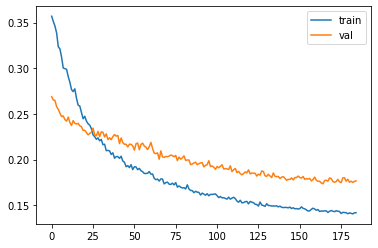

In [156]:
plt.plot(model_trainedapp[1].history['loss'][13:],label="train")
plt.plot(model_trainedapp[1].history['val_loss'][13:],label="val")
plt.legend()
plt.show()

In [163]:
y_pred_approach_test = np.exp(scaleryapp.inverse_transform(model_trainedapp[0].predict(scaled_df_testapp.values).reshape(-1, 1)))
rmseval_app = np.sqrt(mean_squared_error(y_pred_approach_test, y_test))
rmseval_app

495.35564311504766

In [172]:
def train_autoencoderapp(x_train, x_val,encoding_dim,optim, verbose):
    # Set callback functions to early stop training and save the best model so far
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=10),
                ]
    # def autoencode_pd(df):
    # this is the size of our encoded representations
    # this is our input placeholder
    input_img = Input(shape=(x_train.shape[1],))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x_train.shape[1], activation='linear')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer=optimizer, loss='mse')
    autoencoder.fit(x_train, x_train,
                    epochs=300,
                    batch_size=80,
                    shuffle=True,
                    validation_data=(x_val, x_val),
                    verbose=verbose,
                    callbacks=callbacks_best)
    return autoencoder

Train on 9947 samples, validate on 4264 samples
Epoch 1/300
9947/9947 [==============================] - 1s 121us/step - loss: 0.8067 - val_loss: 0.4801
Epoch 2/300
9947/9947 [==============================] - 1s 104us/step - loss: 0.6714 - val_loss: 0.4324
Epoch 3/300
9947/9947 [==============================] - 1s 105us/step - loss: 0.6196 - val_loss: 0.4091
Epoch 4/300
9947/9947 [==============================] - 1s 103us/step - loss: 0.5860 - val_loss: 0.3928
Epoch 5/300
9947/9947 [==============================] - 1s 103us/step - loss: 0.5608 - val_loss: 0.3795
Epoch 6/300
9947/9947 [==============================] - 1s 104us/step - loss: 0.5401 - val_loss: 0.3691
Epoch 7/300
9947/9947 [==============================] - 1s 102us/step - loss: 0.5221 - val_loss: 0.3592
Epoch 8/300
9947/9947 [==============================] - 1s 102us/step - loss: 0.5062 - val_loss: 0.3515
Epoch 9/300
9947/9947 [==============================] - 1s 102us/step - loss: 0.4922 - val_loss: 0.3433
Epoch 1

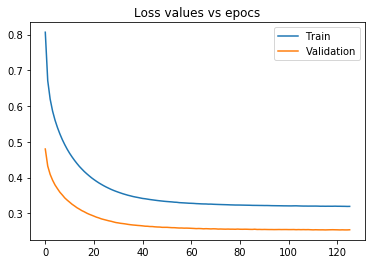

In [174]:
optim = RMSprop(learning_rate=0.001)
autoencoder_approach = train_autoencoderapp(scaled_df_trainapp, scaled_df_valapp, 100, optim, verbose=True)
plt.plot(autoencoder_approach.history.history['loss'],label="Train")
plt.plot(autoencoder_approach.history.history['val_loss'],label="Validation")
plt.title("Loss values vs epocs")
plt.legend()
plt.show()

In [175]:
autoencoder_approach.summary()
autoencoder_approach.layers[0].input_shape

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 421)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 100)               42200     
_________________________________________________________________
dense_151 (Dense)            (None, 421)               42521     
Total params: 84,721
Trainable params: 84,721
Non-trainable params: 0
_________________________________________________________________


(None, 421)

In [182]:
n1=300
n2=200
n3=200
epochs=300
dropout=0.35
optimizer=Adam(learning_rate=0.00025)
model_trained_aenc = tune_params_autoencoder(
    autoencoder_approach,
    scaled_df_trainapp,
    y_train_log_stdapp,
    scaled_df_valapp,
    y_val_log_stdapp,
    n1,
    n2,
    n3,
    scaleryapp,
    epochs,
    optimizer,
    dropout
)


before train: Init time: 1573158200.1
after train, finish time: 1573158307.096
training time {} 106.996
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 100)               42200     
_________________________________________________________________
dense_160 (Dense)            (None, 300)               30300     
_________________________________________________________________
dropout_59 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 200)               60200     
_________________________________________________________________
dropout_60 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 200)               40200     
_______________

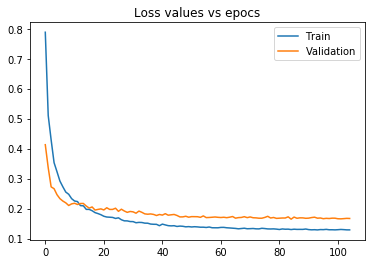

497.00834109724684

In [184]:
plt.plot(model_trained_aenc[1].history['loss'],label="Train")
plt.plot(model_trained_aenc[1].history['val_loss'],label="Validation")
plt.title("Loss values vs epocs")
plt.legend()
plt.show()
y_pred_org_test = np.exp(scaleryapp.inverse_transform(model_trained_aenc[0].predict(scaled_df_testapp.values).reshape(-1, 1)))
rmseval = np.sqrt(mean_squared_error(y_pred_org_test, y_testapp))
rmseval